# Dat550 Project

In [65]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import keras_tuner as kt
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from textblob import TextBlob
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, Dense, GlobalMaxPool1D, Embedding, TextVectorization, MaxPooling1D, LSTM, Concatenate, Dropout, GlobalMaxPooling1D

## Data Loading Functions

In [66]:
# Load articles
def load_articles(filepath):
    articles = []
    with open(filepath, "r", encoding="UTF-8") as f:
        for line in f:
            data = json.loads(line)
            text = data["title"] + " " + data["content"]
            articles.append({
                "id": data["id"],
                "text": text
            })
    return articles

# Load labels
def load_labels(filepath):
    labels = []
    with open(filepath, "r", encoding="UTF-8") as f:
        for line in f:
            data = json.loads(line)
            labels.append({
                "id": str(data["id"]).zfill(7),  # Zero-pad to match article IDs
                "label": 1 if data["hyperpartisan"] else 0
            })
    return labels

## File paths

In [67]:
# df = pd.read_xml("Webis-data/extracted/ground-truth-training-byarticle-20181122.xml")
# df.to_json("preprocessing/data/ground-truth-training-byarticle.jsonl",orient="records",lines=True)

# df = pd.read_xml("Webis-data/extracted/ground-truth-training-bypublisher-20181122.xml")
# df.to_json("preprocessing/data/ground-truth-training-bypublisher.jsonl",orient="records",lines=True)

# df = pd.read_xml("Webis-data/extracted/ground-truth-test-bypublisher-20181212.xml")
# df.to_json("preprocessing/data/ground-truth-test-bypublisher.jsonl",orient="records",lines=True)

# df = pd.read_xml("Webis-data/extracted/ground-truth-test-byarticle-20181207.xml")
# df.to_json("preprocessing/data/ground-truth-test-byarticle.jsonl",orient="records",lines=True)

In [68]:
train_articles_path = "preprocessing/data/articles-training-byarticle.jsonl"
train_labels_path = "preprocessing/data/ground-truth-training-byarticle.jsonl"
test_articles_path  = "preprocessing/data/articles-test-byarticle.jsonl"
test_labels_path    = "preprocessing/data/ground-truth-test-byarticle.jsonl"

## Load and Merge Training Data

In [69]:
train_articles_df = pd.DataFrame(load_articles(train_articles_path))
train_labels_df   = pd.DataFrame(load_labels(train_labels_path))
train_articles_df["id"] = train_articles_df["id"].astype(str)
# Merge training data on 'id'
train_df = pd.merge(train_articles_df, train_labels_df, on="id")
# For training, we only need the text and the label

# Add publication data and such for more feature?

texts_train = train_df["text"].tolist()
labels_train = train_df["label"].values

print("Training data samples:", len(texts_train))

Training data samples: 645


## Load and Merge Test Data

In [70]:
test_articles_df = pd.DataFrame(load_articles(test_articles_path))
test_labels_df   = pd.DataFrame(load_labels(test_labels_path))
test_articles_df["id"] = test_articles_df["id"].astype(str)
# Merge test data on 'id'
test_df = pd.merge(test_articles_df, test_labels_df, on="id")
texts_test = test_df["text"].tolist()
labels_test = test_df["label"].values

print("Test data samples:", len(texts_test))

Test data samples: 628


## Preprocessing the Text with TextVectorization

In [71]:
max_tokens = 10000          # Maximum vocabulary size
max_sequence_length = 200   # Maximum sequence length (adjust as needed)

vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(texts_train)

# Vectorize the texts. The output is a tensor of shape (num_samples, max_sequence_length)
X_train = vectorize_layer(texts_train)
X_test  = vectorize_layer(texts_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (645, 200)
X_test shape: (628, 200)


## Build the Convolutional Neural Network (CNN) Model 

In [72]:
model = Sequential([
    Input(shape=(max_sequence_length,)),
    # Embedding layer maps integer sequences to dense vectors.
    Embedding(input_dim=max_tokens, output_dim=128),
    Conv1D(filters=100, kernel_size=3, activation='relu'),
    GlobalMaxPool1D(),
    # Fully connect the network
    Dense(units=64, activation='relu'),
    # Output layer
    Dense(units=1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 198, 100)       │        38,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,325,029 (5.05 MB)

 Trainable params: 1,325,029 (5.05 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [73]:
history = model.fit(X_train, labels_train, batch_size=16, epochs=10, validation_split=0.2)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6117 - loss: 0.6764 - val_accuracy: 0.7209 - val_loss: 0.6030
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6296 - loss: 0.6000 - val_accuracy: 0.7442 - val_loss: 0.6328
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9528 - loss: 0.5027 - val_accuracy: 0.7287 - val_loss: 0.5934
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9798 - loss: 0.2479 - val_accuracy: 0.7442 - val_loss: 0.5453
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0575 - val_accuracy: 0.7442 - val_loss: 0.5693
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 0.6899 - val_loss: 0.5743
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.6822 - val_loss: 0.5803
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.6899 - v

## Evaluate & Predict on Test Data

Final Evaluation - Loss: 0.6576, Accuracy: 0.6354
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


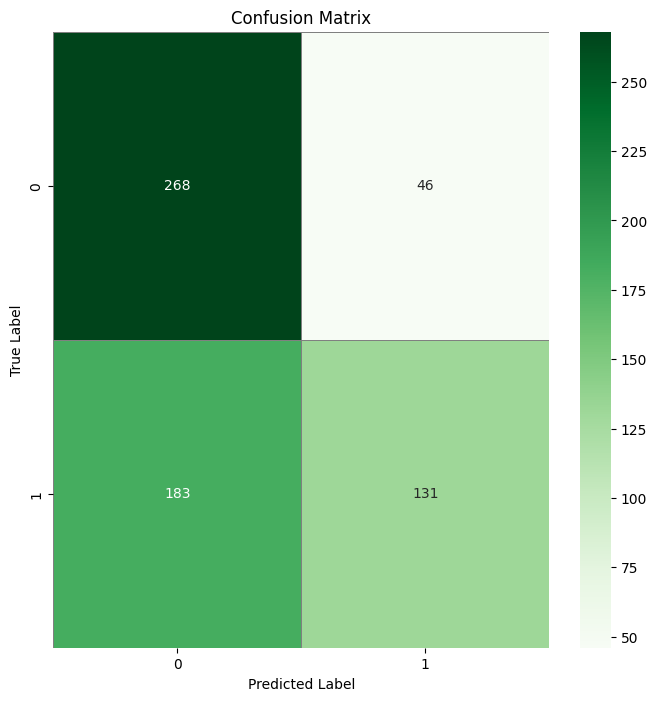

In [74]:
# Evaluate the model on test data and print loss and accuracy:
loss_eval, acc_eval = model.evaluate(X_test, labels_test, verbose=0)
print(f"Final Evaluation - Loss: {loss_eval:.4f}, Accuracy: {acc_eval:.4f}")

# Generate predictions: convert probabilities to 0 or 1 by thresholding at 0.5
predictions = model.predict(X_test)
pred_y = (predictions >= 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(labels_test, pred_y)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt='d', linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Hypermeter tuning

In [75]:
# Add sentiment polarity score
train_df["sentiment"] = train_df["text"].apply(lambda x: TextBlob(x).sentiment.polarity)
test_df["sentiment"] = test_df["text"].apply(lambda x: TextBlob(x).sentiment.polarity)

sentiment_train = train_df["sentiment"].values
sentiment_test = test_df["sentiment"].values

In [76]:
def build_model(hp):
    cnn_input = Input(shape=(max_sequence_length,), name="cnn_input")
    sentiment_input = Input(shape=(1,), name="sentiment_input")

    x = Embedding(input_dim=max_tokens, output_dim=hp.Choice("embedding_dim", [64, 128]))(cnn_input)

    # Use fixed kernel sizes (2, 3, 4) for parallel CNNs
    conv_outputs = []
    for kernel_size in [2, 3, 4]:
        conv = Conv1D(
            filters=hp.Int("filters", min_value=64, max_value=128, step=32),
            kernel_size=kernel_size,
            activation="relu"
        )(x)
        pool = GlobalMaxPool1D()(conv)
        conv_outputs.append(pool)

    x = Concatenate()(conv_outputs)
    x = Concatenate()([x, sentiment_input])

    x = Dense(hp.Int("dense_units", min_value=32, max_value=128, step=32), activation="relu")(x)
    x = Dropout(hp.Float("dropout", 0.3, 0.7, step=0.1))(x)

    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=[cnn_input, sentiment_input], outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [77]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_dir',
    project_name='hyperpartisan_cnn'
)

tuner.search([X_train, sentiment_train], labels_train, epochs=10, batch_size=16, validation_split=0.2)

Reloading Tuner from tuner_dir\hyperpartisan_cnn\tuner0.json


In [88]:
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

# Print the best hyperparameters
print("Best hyperparameters found:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Best hyperparameters found:
embedding_dim: 128
filters: 128
dense_units: 96
dropout: 0.5


c:\Users\Ninh Bao\Documents\skole\DAT550-Project\venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best Model - Loss: 0.6643, Accuracy: 0.6513
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


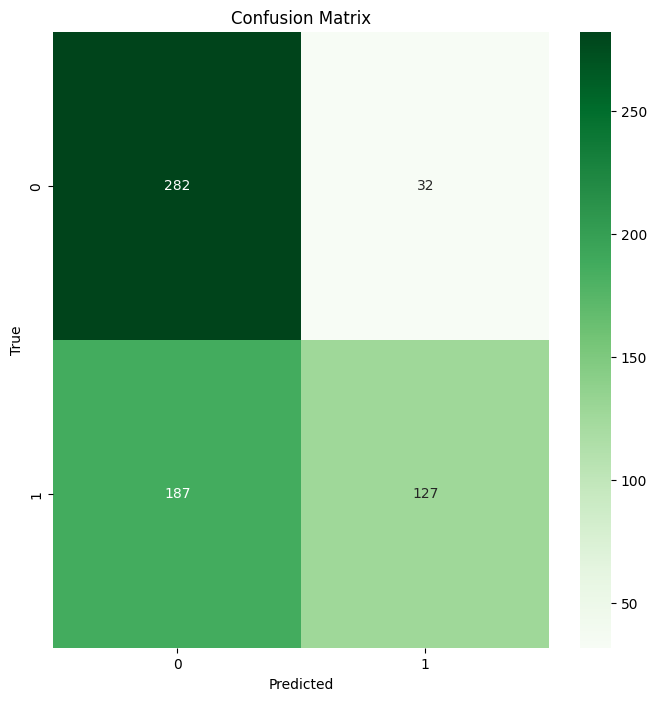

In [78]:
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate
loss_eval_tuner, acc_eval_tuner = best_model.evaluate([X_test, sentiment_test], labels_test, verbose=0)
print(f"Best Model - Loss: {loss_eval_tuner:.4f}, Accuracy: {acc_eval_tuner:.4f}")

# Predictions
predictions_tuner = best_model.predict([X_test, sentiment_test])
pred_y_tuner = (predictions_tuner >= 0.5).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(labels_test, pred_y_tuner)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

LSTM CNN

In [79]:
def build_cnn_lstm_model():
    input_text = Input(shape=(max_sequence_length,))
    embedding = Embedding(input_dim=max_tokens, output_dim=128)(input_text)
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding)
    pool = MaxPooling1D(pool_size=2)(conv)
    lstm = LSTM(units=64, return_sequences=False)(pool)
    dense = Dense(64, activation='relu')(lstm)
    output = Dense(1, activation='sigmoid')(dense)
    
    model = Model(inputs=input_text, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_lstm_model = build_cnn_lstm_model()
cnn_lstm_model.summary()

# Train
cnn_lstm_model.fit(X_train, labels_train, epochs=10, batch_size=16, validation_split=0.2)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 198, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 99, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,382,913 (5.28 MB)

 Trainable params: 1,382,913 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5424 - loss: 0.6809 - val_accuracy: 0.7209 - val_loss: 0.6337
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6502 - loss: 0.6251 - val_accuracy: 0.6357 - val_loss: 0.6127
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8726 - loss: 0.3689 - val_accuracy: 0.6357 - val_loss: 0.6540
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9408 - loss: 0.2141 - val_accuracy: 0.5969 - val_loss: 1.0217
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9727 - loss: 0.0811 - val_accuracy: 0.6589 - val_loss: 1.0659
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9689 - loss: 0.0894 - val_accuracy: 0.6357 - val_loss: 1.2453
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9745 - loss: 0.0787 - val_accuracy: 0.6434 - val_loss: 1.3991
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9719 - loss: 0.0768 - val_accuracy: 0.6512 - v

Best Model - Loss: 1.8206, Accuracy: 0.5828
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


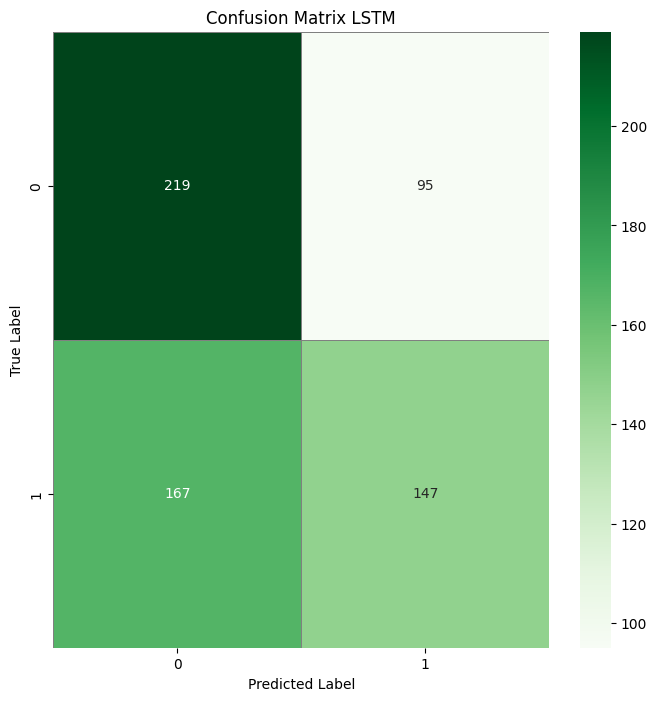

In [80]:
loss_eval_lstm, acc_eval_lstm = cnn_lstm_model.evaluate(X_test, labels_test, verbose=0)
print(f"Best Model - Loss: {loss_eval_lstm:.4f}, Accuracy: {acc_eval_lstm:.4f}")

predictions_lstm = cnn_lstm_model.predict(X_test)
pred_y_lstm = (predictions_lstm >= 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(labels_test, pred_y_lstm)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt='d', linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix LSTM")
plt.show()

BERT CNN

In [81]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_bert(texts, max_len=256):
    return tokenizer(
        texts,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )

train_encodings = tokenize_bert(texts_train)
test_encodings = tokenize_bert(texts_test)

In [90]:
def build_bert_cnn_model():
    # Inputs
    input_ids = Input(shape=(256,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(256,), dtype=tf.int32, name="attention_mask")

    # Load BERT
    bert_model = TFBertModel.from_pretrained("bert-base-uncased")

    # Get BERT embeddings using Keras Lambda layer
    def get_bert_embeddings(inputs):
        return bert_model(inputs)[0]

    bert_output = tf.keras.layers.Lambda(
    get_bert_embeddings,
    output_shape=(256, 768)
    )({
        "input_ids": input_ids,
        "attention_mask": attention_mask
    })

    # CNN Layers
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(bert_output)
    pooled = GlobalMaxPooling1D()(conv)
    dense = Dense(64, activation='relu')(pooled)
    dropout = Dropout(0.5)(dense)
    output = Dense(1, activation='sigmoid')(dropout)

    # Build Model
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


bert_cnn_model = build_bert_cnn_model()
bert_cnn_model.summary()

# Train
bert_cnn_model.fit(
    x={"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    y=labels_train,
    epochs=3,
    batch_size=8,
    validation_split=0.1
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256, 768)  │          0 │ attention_mask[0… │
│                     │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 254, 128)  │    295,040 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 303,361 (1.16 MB)

 Trainable params: 303,361 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.5430 - loss: 0.9958 - val_accuracy: 0.6154 - val_loss: 0.6435
Epoch 2/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.7449 - loss: 0.5461 - val_accuracy: 0.6308 - val_loss: 0.6401
Epoch 3/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.7846 - loss: 0.4731 - val_accuracy: 0.8154 - val_loss: 0.4709


20/20 ━━━━━━━━━━━━━━━━━━━━ 113s 6s/step - accuracy: 0.7955 - loss: 0.4510
Best Model - Loss: 0.4395, Accuracy: 0.7882
20/20 ━━━━━━━━━━━━━━━━━━━━ 117s 6s/step


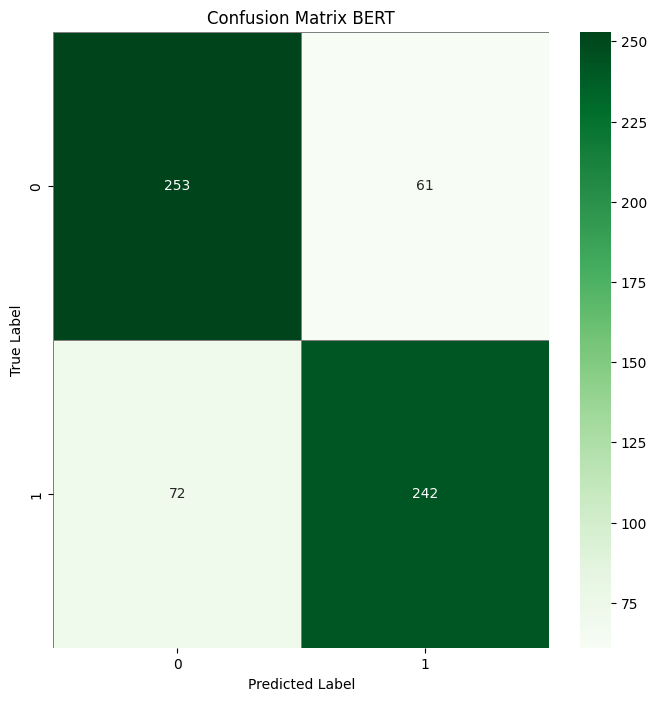

In [91]:
x_test = {
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"]
}

loss_eval_bert, acc_eval_bert = bert_cnn_model.evaluate(x=x_test, y=labels_test)
print(f"Best Model - Loss: {loss_eval_bert:.4f}, Accuracy: {acc_eval_bert:.4f}")

predictions_bert = bert_cnn_model.predict(x_test)
pred_y_bert = (predictions_bert >= 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(labels_test, pred_y_bert)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt='d', linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix BERT")
plt.show()

In [92]:
print("CNN Report:\n", classification_report(labels_test, pred_y))
print("CNN-LSTM Report:\n", classification_report(labels_test, pred_y_lstm))
print("CNN-Bert Report:\n", classification_report(labels_test, pred_y_bert))

CNN Report:
               precision    recall  f1-score   support

           0       0.59      0.85      0.70       314
           1       0.74      0.42      0.53       314

    accuracy                           0.64       628
   macro avg       0.67      0.64      0.62       628
weighted avg       0.67      0.64      0.62       628

CNN-LSTM Report:
               precision    recall  f1-score   support

           0       0.57      0.70      0.63       314
           1       0.61      0.47      0.53       314

    accuracy                           0.58       628
   macro avg       0.59      0.58      0.58       628
weighted avg       0.59      0.58      0.58       628

CNN-Bert Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79       314
           1       0.80      0.77      0.78       314

    accuracy                           0.79       628
   macro avg       0.79      0.79      0.79       628
weighted avg       0.79  